# Plot nucleolous object features for CX5461 and unperturbed

In [1]:
from campa.tl import Experiment, FeatureExtractor, thresholded_count, thresholded_median
from campa_ana.constants import SOURCE_DIR
from pathlib import Path
from campa.pl import hex2rgb
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad

Reading config from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


In [2]:
fig_dir = Path(SOURCE_DIR)/'figures'/'fig4'
os.makedirs(str(fig_dir), exist_ok=True)

In [3]:
def add_perturbation_plot(adata):
    # create perturbation_plot column from perturbation_duration column
    p = np.array(adata.obs['perturbation_duration'])
    p[p == 'AZD4573-120'] = 'AZD4573 (2.5h)'
    p[p == 'AZD4573-30'] = 'AZD4573 (1h)'
    p[p == 'CX5461-120'] = 'CX5461 (2.5h)'
    p[p == 'Meayamycin-720'] = 'Meayamycin (12.5h)'
    p[p == 'TSA-30'] = 'TSA (1h)'
    p[p == 'Triptolide-120'] = 'Triptolide (2.5h)'
    p[np.in1d(p, ['DMSO-120', 'DMSO-720', 'normal'])] = 'unperturbed'
    adata.obs['perturbation_plot'] = p
    adata.obs['perturbation_plot'] = adata.obs['perturbation_plot'].astype('category')
    print(adata.obs['perturbation_plot'].cat.categories)
    adata.uns['perturbation_plot_colors'] = ['#377eb8', '#984ea3', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#999999']  #https://gist.github.com/thriveth/8560036


In [4]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
extrs = {data_dir: FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_annotation.h5ad')) 
    for data_dir in exp.data_params['data_dirs']}

In [5]:
# aggregate object statistics, using additional thresholding
for extr in extrs.values():
    _ = extr.get_object_stats(area_threshold=10, agg=['median', thresholded_count, thresholded_median])
# combined adatas for plotting
adata_object_stats = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')

In [6]:
#adata = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')
add_perturbation_plot(adata_object_stats)

Index(['AZD4573 (1h)', 'AZD4573 (2.5h)', 'CX5461 (2.5h)', 'Meayamycin (12.5h)',
       'TSA (1h)', 'Triptolide (2.5h)', 'unperturbed'],
      dtype='object')


In [7]:
cats = ['unperturbed', 'CX5461 (2.5h)']
colors = [adata_object_stats.uns['perturbation_plot_colors'][list(adata_object_stats.obs['perturbation_plot'].cat.categories).index(c)] for c in cats]
colors = np.array(list(map(hex2rgb, colors)))/256.

Text(0, 0.5, 'Area (% of Nucleolus)')

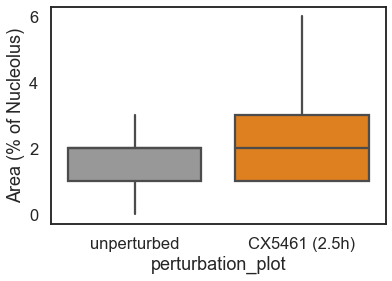

In [8]:
sns.set_style('white')
sns.set_context('talk')

df = adata_object_stats.obsm['size'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
df['nucleolus_fraction'] = df['Nucleolus'] / df['all'] * 100

# object count
#ax = axes[0][0]
df = adata_object_stats.obsm['object_stats_agg'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
g = sns.boxplot(data=df, y='area_thresholded_count|Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False)# ax=ax)
g.set_ylabel('Area (% of Nucleolus)')

In [9]:
adata_object_stats.obs[['perturbation', 'well_name']].value_counts()

perturbation  well_name
AZD4573       I17          737
normal        J10          676
              J12          668
AZD4573       J21          654
              J18          652
normal        I11          645
TSA           I16          617
DMSO          J16          606
TSA           J20          600
CX5461        J22          570
              I18          562
normal        I09          557
AZD4573       J14          551
              I13          534
DMSO          I14          528
Triptolide    J15          512
              I10          506
TSA           J13          498
Meayamycin    I20          438
CX5461        J09          420
Meayamycin    I12          317
dtype: int64

In [10]:
df['perturbation_plot'].value_counts()

unperturbed           3680
AZD4573 (1h)          1942
TSA (1h)              1715
CX5461 (2.5h)         1552
AZD4573 (2.5h)        1186
Triptolide (2.5h)     1018
Meayamycin (12.5h)     755
Name: perturbation_plot, dtype: int64

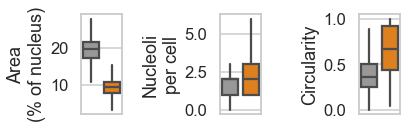

In [11]:
sns.set_style('whitegrid')
sns.set_context('talk')

fig, axes = plt.subplots(1,3, figsize=(6,2), sharex=True, squeeze=False)
# total area 
#ax = axes[0][0]
#df = adata_object_stats.obsm['size'].copy()
#df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
#sns.boxplot(data=df, y='Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
#ax.set_ylabel('Total area (px)')

# relative area
ax = axes[0][0]
df = adata_object_stats.obsm['size'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
df['nucleolus_fraction'] = df['Nucleolus'] / df['all'] * 100
g = sns.boxplot(data=df, y='nucleolus_fraction', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
g.set_ylabel('Area\n(% of nucleus)')

# object count
ax = axes[0][1]
df = adata_object_stats.obsm['object_stats_agg'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
sns.boxplot(data=df, y='area_thresholded_count|Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
ax.set_ylabel('Nucleoli\nper cell')

# circularity
ax = axes[0][2]
df = adata_object_stats.obsm['object_stats_agg'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
sns.boxplot(data=df, y='circularity_thresholded_median|Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
ax.set_ylabel('Circularity')


for ax in axes.flat:
    ax.set_xlabel('')
    ax.set_xticklabels([])
    #ax.set_xticklabels(cats, rotation = 90)
plt.tight_layout()
plt.savefig(fig_dir/'object_features_CX5461.pdf', dpi=300, bbox_inches='tight')

KeyError: 'object_count'

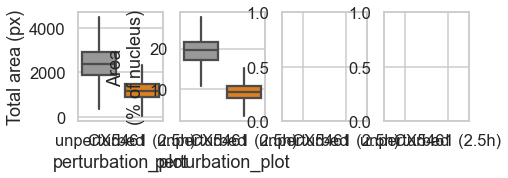

In [12]:
sns.set_style('whitegrid')
sns.set_context('talk')

fig, axes = plt.subplots(1,4, figsize=(7,2), sharex=True, squeeze=False)
# total area 
ax = axes[0][0]
df = adata_object_stats.obsm['size'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
sns.boxplot(data=df, y='Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
ax.set_ylabel('Total area (px)')

# relative area
ax = axes[0][1]
df = adata_object_stats.obsm['size'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
df['nucleolus_fraction'] = df['Nucleolus'] / df['all'] * 100
g = sns.boxplot(data=df, y='nucleolus_fraction', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
g.set_ylabel('Area\n(% of nucleus)')

# object count
ax = axes[0][2]
df = adata_object_stats.obsm['object_count'].copy()
df['perturbation_plot'] = adata_object_stats.obs['perturbation_plot']
sns.boxplot(data=df, y='Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
ax.set_ylabel('Nucleoli\nper cell')

# circularity
ax = axes[0][3]
df = adata_object_stats.obsm['object_circularity_median'].copy()
df['perturbation_plot'] = adata.obs['perturbation_plot']
sns.boxplot(data=df, y='Nucleolus', x='perturbation_plot', order=cats, palette=colors, showfliers=False, showcaps=False, ax=ax)
ax.set_ylabel('Circularity')


for ax in axes.flat:
    ax.set_xlabel('')
    ax.set_xticklabels([])
    #ax.set_xticklabels(cats, rotation = 90)
plt.tight_layout()
plt.savefig(fig_dir/'object_features_CX5461.png', dpi=300)


## Suppl fig: plot number of nucleolus before and after filtering

In [13]:
agg_stats = adata_object_stats.obsm['object_stats_agg']
agg_stats['perturbation'] = adata_object_stats.obs['perturbation_plot']
agg_stats = agg_stats[np.in1d(adata_object_stats.obs['perturbation_plot'], cats)]
agg_stats['perturbation'] = list(agg_stats['perturbation'])

/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_339/267920546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_stats['perturbation'] = list(agg_stats['perturbation'])


In [14]:
agg_stats

,area_median|Cajal bodies,area_median|Extra-nuclear,area_median|Nuclear periphery,area_median|Nuclear speckles,area_median|Nucleolus,area_median|Nucleoplasm,area_median|PML bodies,area_thresholded_count|Cajal bodies,area_thresholded_count|Extra-nuclear,area_thresholded_count|Nuclear periphery,...,extent_thresholded_median|Nucleoplasm,extent_thresholded_median|PML bodies,count|Cajal bodies,count|Extra-nuclear,count|Nuclear periphery,count|Nuclear speckles,count|Nucleolus,count|Nucleoplasm,count|PML bodies,perturbation
0-0,12.5,18.0,19.5,62.0,1015.0,4152.0,83.0,2.0,1.0,7.0,...,0.471589,0.666558,2.0,6.0,10.0,23.0,3.0,2.0,15.0,unperturbed
1-0,0.0,107.0,45.0,13.0,213.0,4581.0,35.0,0.0,2.0,3.0,...,0.544385,0.694444,0.0,3.0,4.0,2.0,3.0,1.0,7.0,unperturbed
2-0,17.0,28.5,42.0,76.0,1034.0,6103.0,40.0,1.0,5.0,5.0,...,0.442054,0.700000,1.0,8.0,9.0,11.0,2.0,1.0,12.0,unperturbed
3-0,0.0,73.0,29.5,92.5,713.0,2952.5,52.0,0.0,2.0,5.0,...,0.347158,0.703297,0.0,5.0,6.0,12.0,3.0,2.0,9.0,unperturbed
4-0,12.0,36.0,70.5,100.0,818.0,3645.0,55.0,3.0,1.0,6.0,...,0.561077,0.651515,3.0,4.0,10.0,19.0,3.0,2.0,13.0,unperturbed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565-13,12.0,47.0,29.0,67.0,21.0,149.5,104.0,1.0,1.0,8.0,...,0.255937,0.663265,1.0,3.0,15.0,10.0,9.0,4.0,7.0,CX5461 (2.5h)
566-13,13.0,1307.0,1426.0,37.0,132.0,4571.0,50.0,1.0,1.0,1.0,...,0.525402,0.698413,1.0,1.0,1.0,11.0,1.0,1.0,8.0,CX5461 (2.5h)
567-13,19.0,1951.0,63.0,57.0,790.5,30.5,65.0,7.0,1.0,6.0,...,0.395083,0.672210,9.0,1.0,13.0,13.0,2.0,6.0,7.0,CX5461 (2.5h)
568-13,11.5,14.5,14.0,89.0,50.0,20.0,33.0,4.0,1.0,1.0,...,0.428571,0.656250,4.0,4.0,4.0,15.0,4.0,3.0,18.0,CX5461 (2.5h)


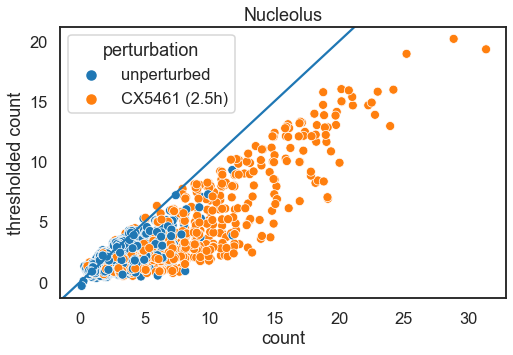

In [22]:
sns.set_style('white')
sns.set_context('talk')

def jitter(values,j=0):
    return values + np.random.normal(j,0.2,values.shape)

order = np.random.permutation(np.arange(len(agg_stats)))
agg_stats = agg_stats.iloc[order]

for cluster in ['Nucleolus']:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=jitter(agg_stats[f"count|{cluster}"]), y=jitter(agg_stats[f'area_thresholded_count|{cluster}']), hue=agg_stats['perturbation'], rasterized=True)
    plt.axline((0,0), slope=1)
    plt.ylabel('thresholded count')
    plt.xlabel('count')
    plt.title(cluster)
    plt.savefig(fig_dir/f'suppl_scatter_counts_{cluster}.pdf', dpi=200, bbox_inches='tight')